In [24]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from math import sin
np.random.seed(1976)
tf.random.set_seed(1976)

In [25]:
L=2                                 # number of fidelity levels
X_c=np.array([[0],[0.2],[0.5],[0.8],[1]]) # initial samples for the coarse model 
X_e=np.array([[0],[0.4],[0.6],[1]]) # initial samples for the fine model 
num_initial_points_e=len(X_e)
num_initial_points_c=len(X_c)
n=[num_initial_points_c,num_initial_points_e]
def fe(x):                          # the expensive function 
    return(6*x-2)*(6*x-2)*tf.sin(12*x-4)
def fc(x):                          # the approximation 
    return(1/2*fe(x)+10*(x-1/2)-5)

## the observers 
from trieste.data import Dataset
OBJECTIVE = "OBJECTIVE"
def observer_c(query_points_c ):
    return {
        OBJECTIVE: Dataset(query_points_c, fc(query_points_c))
    }
def observer_e(query_points_e):
    return {
        OBJECTIVE: Dataset(query_points_e, fe(query_points_e))
    }
def normalization(observations):
    Y_max=np.max(observations)
    Y_min=np.min(observations)
    return (observations-1/2*(Y_max+Y_min))/(1/2*(Y_max-Y_min)) 

initial_data_c = observer_c(X_c)
initial_data_e = observer_e(X_e)
data_X=[initial_data_c[OBJECTIVE].query_points[:],initial_data_e[OBJECTIVE].query_points[:]]
Y=[initial_data_c[OBJECTIVE].observations[:].numpy() ,initial_data_e[OBJECTIVE].observations[:].numpy()] 
data_Y=[normalization(initial_data_c[OBJECTIVE].observations[:].numpy()) ,normalization(initial_data_e[OBJECTIVE].observations[:].numpy())]
#data_Y=
model=[_, _]
k=[_,_]
sigma_epsilon=[_,_]
k_inv=[_,_]
Y_max=[np.max(initial_data_c[OBJECTIVE].observations[:].numpy()),np.max(initial_data_e[OBJECTIVE].observations[:].numpy())]
Y_min=[np.min(initial_data_c[OBJECTIVE].observations[:].numpy()),np.min(initial_data_e[OBJECTIVE].observations[:].numpy())]

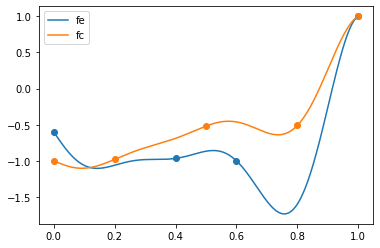

In [26]:
List=np.arange(0,1,0.001)
plt.plot(List,(fe(List)-1/2*(Y_max[1]+Y_min[1]))/(1/2*(Y_max[1]-Y_min[1])) , label='fe')
plt.plot(List,(fc(List)-1/2*(Y_max[0]+Y_min[0]))/(1/2*(Y_max[0]-Y_min[0])), label='fc')
plt.scatter(data_X[1],data_Y[1])
plt.scatter(data_X[0],data_Y[0])
plt.legend()

# Building the initial models

## coarse model 

In [27]:
k_1=gpflow.kernels.RBF(1)
theta=gpflow.kernels.Constant()
k[0]=k_1+theta 
model[0]=gpflow.models.GPR((data_X[0], data_Y[0]),k[0],noise_variance=1e-5)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model[0].training_loss,variables=model[0].trainable_variables,options=dict(disp=True, maxiter=100),)
sigma_epsilon[0]=np.sqrt(float(model[0].likelihood.variance.numpy()))
k_inv[0]=np.linalg.inv(k[0](data_X[0])+sigma_epsilon[0]**2*np.eye(n[0]))
## correlation vector
def K_c(x):
    
    if isinstance(x, np.float64):
        K=k[0](x,data_X[0]).reshape((1,n[0]))
    else:
        K=k[0](x,data_X[0])
    return K.numpy().T
##  correlation coefficient
def k_coef_c(x):
    if len(x)==1:
        return k[0](x,x).numpy()
    else :
        return k[0](x,x).numpy().diagonal().reshape((len(x),1))
    
def predict_c(x):
    mean=np.dot(K_c(x).T,np.dot(k_inv[0],data_Y[0]))
    if len(x)==1:
        var=k_coef_c(x)+sigma_epsilon[0]**2-np.dot(K_c(x).T,np.dot(k_inv[0],K_c(x))).reshape(len(x),1)
    else:
        var=k_coef_c(x)+sigma_epsilon[0]**2-np.dot(K_c(x).T,np.dot(k_inv[0],K_c(x))).diagonal().reshape(len(x),1)    
    return mean,var 



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13878D+03    |proj g|=  1.20821D+04

At iterate    1    f=  6.73348D+01    |proj g|=  3.28606D+02

At iterate    2    f=  5.88831D+01    |proj g|=  2.83865D+02

At iterate    3    f=  2.65150D+01    |proj g|=  1.11087D+02

At iterate    4    f=  1.71139D+01    |proj g|=  6.02457D+01

At iterate    5    f=  1.13856D+01    |proj g|=  2.87657D+01

At iterate    6    f=  8.83249D+00    |proj g|=  1.42703D+01

At iterate    7    f=  7.59748D+00    |proj g|=  6.83315D+00

At iterate    8    f=  7.05487D+00    |proj g|=  3.21449D+00

At iterate    9    f=  6.82986D+00    |proj g|=  1.44963D+00

At iterate   10    f=  6.74361D+00    |proj g|=  6.08596D-01

At iterate   11    f=  6.70545D+00    |proj g|=  2.15388D-01

At iterate   12    f=  6.66856D+00    |proj g|=  2.64574D-01

At iterate   13    f=  6.5

 This problem is unconstrained.


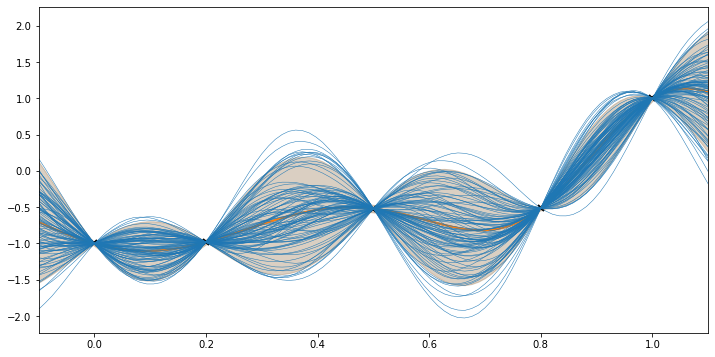

In [28]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)


## predict mean and variance of latent GP at test points
mean_c, var_c = model[0].predict_f(xx)
mean, var=predict_c(xx)
## generate 10 samples from posterior
samples = model[0].predict_f_samples(xx, 100) # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(data_X[0], data_Y[0], 'kx', mew=2)
plt.plot(xx, mean_c, 'C0', label='predict_f',lw=2)
plt.plot(xx, mean, 'C1', label='predict_c', lw=2)
plt.fill_between(xx[:,0],
                 mean_c[:,0] - 1.96 * np.sqrt(var_c[:,0]),
                 mean_c[:,0] + 1.96 * np.sqrt(var_c[:,0]),
                 color='C0', alpha=0.2)

plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C1', alpha=0.2)
plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);

In [29]:
model[0]

<gpflow.models.gpr.GPR object at 0x7fc9fe7350c0>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.724467    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.164813    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.48168e-07 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.24986e-05 │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════╛

## the MF-model 

In [30]:
prev_model_obsv,_=predict_c(data_X[1])

import math
def neg_log_likelihood(par, X_e,Y_e,Y_c):
    Ro,l,var,theta, sigma_epsilon=par 
    dist_X_e = (X_e - X_e.T)**2
    k = var*np.exp(-(1/(2*(l**2)))*dist_X_e)+theta
    n=len(X_e)
    return -(-n/2*np.log(2*np.pi)-1/2*np.log(np.linalg.det(k+(sigma_epsilon**2)*np.eye(n)))-1/2*np.dot(np.dot(( Y_e-Ro*Y_c).T,np.linalg.inv(k+(sigma_epsilon**2)*np.eye(n))),(Y_e-Ro*Y_c)))

from scipy.optimize import minimize 
start =  [0.1,0.1, 0.5,0.01,0.01]

min=minimize(neg_log_likelihood, start, args=(data_X[1],data_Y[1],prev_model_obsv), bounds=[(-np.inf,np.inf),(1.1e-6,2),(1e-4,30**2),(1e-4,np.inf),(1e-4,np.inf)],method='L-BFGS-B',options = {'disp':True,'maxiter':1000})

k_2=gpflow.kernels.RBF(min.x[2],min.x[1])
theta=gpflow.kernels.Constant(min.x[3])
k[1]=k_2+theta
ro=[min.x[0]]

sigma_epsilon[1]=min.x[4]
k_inv[1]=np.linalg.inv(k[1](data_X[1])+sigma_epsilon[1]**2*np.eye(n[1]))
## correlation vector
def K_MF(x):

    if isinstance(x, np.float64):
        K=k[1](x,data_X[1]).reshape(1,n[1])
    else:
        
        K=k[1](x,data_X[1])
    return K.numpy().T
## correlation coefficient
def k_coef_MF(x):
    if len(x)==1:
        return k[1](x,x).numpy()
    else :
        return k[1](x,x).numpy().diagonal().reshape((len(x),1))



def f_hat(x) :
    Y_e=data_Y[1]
    Y_c,var=predict_c(data_X[1])
    mean_c, var_c= predict_c(x)
    
    return (min.x[0]*mean_c+np.dot(np.dot(K_MF(x).T, k_inv[1]),Y_e-min.x[0]*Y_c))
def sigma_square_hat(x):
    mean_c, var_c= predict_c(x)
    
    if len(x)==1:
        
        return (pow(min.x[0],2)*var_c+sigma_epsilon[1]**2+k_coef_MF(x)-np.dot(np.dot(K_MF(x).T, k_inv[1]),K_MF(x)).reshape(len(x),1))
    else :
        return (pow(min.x[0],2)*var_c+sigma_epsilon[1]**2+k_coef_MF(x)-np.dot(np.dot(K_MF(x).T, k_inv[1]),K_MF(x)).diagonal().reshape(len(x),1))
    

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.84924D+00    |proj g|=  4.75002D+00

At iterate    1    f=  2.91830D+00    |proj g|=  2.25770D+00

At iterate    2    f=  1.67248D+00    |proj g|=  1.60228D+00

At iterate    3    f=  1.56196D+00    |proj g|=  4.48176D-01

At iterate    4    f=  1.52075D+00    |proj g|=  6.21772D-01

At iterate    5    f=  1.38594D+00    |proj g|=  2.22798D+00

At iterate    6    f=  1.14427D+00    |proj g|=  1.53378D+00

At iterate    7    f=  8.69498D-01    |proj g|=  1.86506D+00

At iterate    8    f=  8.05636D-01    |proj g|=  1.76166D+00

At iterate    9    f=  7.91426D-01    |proj g|=  1.81862D+00

At iterate   10    f=  7.43384D-01    |proj g|=  7.18857D-01

At iterate   11    f=  7.42073D-01    |proj g|=  2.01337D-01

At iterate   12    f=  7.40339D-01    |proj g|=  2.80579D-02

At iterate   13    f=  7.4

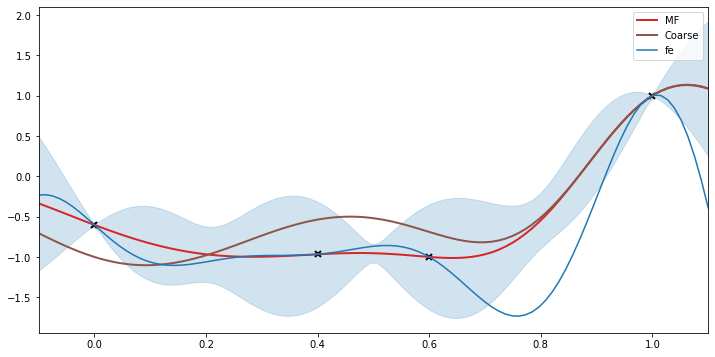

In [31]:
## plot 
plt.figure(figsize=(12, 6))
plt.plot(data_X[1], data_Y[1], 'kx', mew=2)
plt.plot(xx, f_hat(xx), 'C3', label='MF',lw=2)
#plt.plot(xx, mean_e, 'C2', label='HF',lw=2)
plt.plot(xx, mean_c, 'C5', label='Coarse',lw=2)
#plt.plot(xx, mean_e, 'C2', label='fine',lw=2)
plt.plot(xx,(fe(xx)-1/2*(Y_max[1]+Y_min[1]))/(1/2*(Y_max[1]-Y_min[1])),'C0', label="fe")

plt.fill_between(xx[:,0],
                f_hat(xx)[:,0] - 1.96 * np.sqrt(sigma_square_hat(xx)[:,0]),
                f_hat(xx)[:,0] + 1.96 * np.sqrt(sigma_square_hat(xx)[:,0]),
                color='C0', alpha=0.2)

plt.legend()

plt.xlim(-0.1, 1.1);

# proceeding with the optimization 

In [32]:
## the current effective best 
DoE=np.concatenate((data_X[0],data_X[1])) ##desig of experiment 
x_best=DoE[np.argmin(f_hat(DoE))].reshape(1,dim)
x_best


array([[0.2]])

In [33]:



def u(x): ## ex:  x=np.array([[0.5]])
   
    return (f_hat(x_best)-f_hat(x))/np.sqrt(sigma_square_hat(x))

from scipy.stats import norm
def EI(x):
    return (np.sqrt(sigma_square_hat(x))*[u(x)*norm.cdf(u(x))+norm.pdf(u(x))]).reshape(x.shape)

def AEI_L(x):
    return (EI(x)*(1-sigma_epsilon[1]/np.sqrt(sigma_square_hat(x)+sigma_epsilon[1]**2)))

def predictive_variance_update_NN(X,x_star,l_star=2):## X is  nD array 
    try:
        
        if isinstance(X,(np.float64,float)) :
            if l_star==1:
                M1= np.concatenate((K_c(X).T, k[0](X,x_star).numpy().reshape(1,1)),axis=1)
                array1=np.concatenate((k[0](data_X[0])+(sigma_epsilon[0])**2*np.eye(n[0]),K_c(x_star)),axis=1) 
                array2=np.concatenate((K_c(x_star).T,k_coef_c(x_star)+sigma_epsilon[0]**2),axis=1)                    
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=np.dot(np.dot(M1,np.linalg.inv(M2)),M1.T)-np.dot(np.dot(K_c(X).T,k_inv[0]),K_c(X))
            elif l_star==2:
                M1= np.concatenate((K_MF(X).T, k[1](X,x_star).numpy().reshape(1,1)),axis=1)
                array1=np.concatenate((k[1](data_X[1])+(sigma_epsilon[1])**2*np.eye(n[1]),K_MF(x_star)),axis=1) 
                array2=np.concatenate((K_MF(x_star).T,k_coef_MF(x_star)+sigma_epsilon[1]**2),axis=1)                    
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=np.dot(np.dot(M1,np.linalg.inv(M2)),M1.T)-np.dot(np.dot(K_MF(X).T,k_inv[1]),K_MF(X))
            return predictive_variance_update
        ## x_star id 1D array
        elif len(X)==1:
            X=X.reshape(1,1)
            if l_star==1:
                M1= np.concatenate((K_c(X).T, k[0](X,x_star).numpy().reshape(1,1)),axis=1)
                array1=np.concatenate((k[0](data_X[0])+(sigma_epsilon[0])**2*np.eye(n[0]),K_c(x_star)),axis=1) 
                array2=np.concatenate((K_c(x_star).T,k_coef_c(x_star)+sigma_epsilon[0]**2),axis=1)                    
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=np.dot(np.dot(M1,np.linalg.inv(M2)),M1.T)-np.dot(np.dot(K_c(X).T,k_inv[0]),K_c(X))
            elif l_star==2:
                M1= np.concatenate((K_MF(X).T, k[1](X,x_star).numpy().reshape(1,1)),axis=1)
                array1=np.concatenate((k[1](data_X[1])+(sigma_epsilon[1])**2*np.eye(n[1]),K_MF(x_star)),axis=1) 
                array2=np.concatenate((K_MF(x_star).T,k_coef_MF(x_star)+sigma_epsilon[1]**2),axis=1)                    
                M2=np.concatenate((array1,array2),axis=0)
                predictive_variance_update=np.dot(np.dot(M1,np.linalg.inv(M2)),M1.T)-np.dot(np.dot(K_MF(X).T,k_inv[1]),K_MF(X))
            return predictive_variance_update
    except  TypeError:
        print('check dimension')
        
        

def predictive_variance_update(X,x_star,l):
    P=1
    if (l<L):
        for j in range(l,L):
                 P*=ro[j-1]**2
    return P*predictive_variance_update_NN(X,x_star,l)

def max_(a,X):
    L=np.zeros((len(X),1))
    for i in range(len(X)):
        if(float(X[i])>a) :
            L[i]=X[i]
        else:
            L[i]=a
    return L
W=np.ones(L)
W[0]=1
W[1]=10

def MF_AEI(x,l=2):
    if isinstance(x, (np.float64, float)):
        update=predictive_variance_update(x,x,l)/sigma_square_hat(x)
    else: 
        update=np.zeros((len(x),1))
        for i in range(len(x)):
            update[i]=predictive_variance_update(x[i].reshape(1,1),x[i].reshape(1,1),l)/sigma_square_hat(x[i].reshape(1,1))
    return AEI_L(x)*W[1]/W[l-1] *max_(0,update)

def neg_MF_AEI_2(x):
    return -MF_AEI(x,2)
def neg_MF_AEI_1(x):
    return -MF_AEI(x,1)



def predict( model_, x) : 
    if (model_ is model[0]):
        return predict_c(x)
    elif (model_ is  model[1]):
        return f_hat(x)
    
    
## Building the first model .... already done \

f=[fc,fe]
best_observation=[x_best, 2] ### the initialization 





iteration : 0


/tmp/ipykernel_1983432/2208274538.py:25: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  best_observation_parallel[opt]=[min1.x.reshape(1,1),int(1)]


iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19


/tmp/ipykernel_1983432/2208274538.py:21: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  best_observation_parallel[opt]=[min2.x.reshape(1,1),int(2)]


iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19393D+00    |proj g|=  4.86782D-01

At iterate    1    f=  6.17725D+00    |proj g|=  7.64000D-02

At iterate    2    f=  6.17661D+00    |proj g|=  4.93152D-02

At iterate    3    f=  6.17598D+00    |proj g|=  5.92491D-02

At iterate    4    f=  6.17488D+00    |proj g|=  4.50056D-02

At iterate    5    f=  6.17476D+00    |proj g|=  1.00977D-03

At iterate    6    f=  6.17476D+00    |proj g|=  2.76428D-05

At iterate    7    f=  6.17476D+00    |proj g|=  1.45043D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy

 This problem is unconstrained.


iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.81128D+00    |proj g|=  2.81061D+00

At iterate    1    f=  5.56470D+00    |proj g|=  1.29673D+00

At iterate    2    f=  5.52612D+00    |proj g|=  2.79109D-01

At iterate    3    f=  5.52102D+00    |proj g|=  3.21073D-01

At iterate    4    f=  5.50947D+00    |proj g|=  4.30597D-01

At iterate    5    f=  5.48699D+00    |proj g|=  6.98599D-01

At iterate    6    f=  5.46676D+00    |proj g|=  4.00152D-01

At iterate    7    f=  5.46191D+00    |proj g|=  6.29215D-02

At iterate    8    f=  5.46174D+00    |proj g|=  1.39220D-03

At iterate    9    f=  5.46174D+00    |proj g|=  1.54645D-03

At iterate   10    f=  5.46174D+00    |proj g|=  2.51448D-04

At iterate   11    f=  5.46174D+00    |proj g|=  3.48111D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.
/tmp/ipykernel_1983432/2758693064.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  k = var*np.exp(-(1/(2*(l**2)))*dist_X_e)+theta
/tmp/ipykernel_1983432/2758693064.py:7: RuntimeWarning: invalid value encountered in multiply
  k = var*np.exp(-(1/(2*(l**2)))*dist_X_e)+theta
/usr/lib64/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.37640D-01    |proj g|=  2.14963D+00

At iterate    1    f= -8.53606D-01    |proj g|=  2.93197D-01

At iterate    2    f= -9.04485D-01    |proj g|=  8.03328D-01

At iterate    3    f= -1.01705D+00    |proj g|=  1.54581D+00

At iterate    4    f= -1.07391D+00    |proj g|=  8.40526D-01

At iterate    5    f= -1.21792D+00    |proj g|=  6.71974D-01

At iterate    6    f= -1.24659D+00    |proj g|=  3.91400D-01

At iterate    7    f= -1.26217D+00    |proj g|=

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


iteration : 0
iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09941D+00    |proj g|=  8.73896D-01

At iterate    1    f= -5.10502D+00    |proj g|=  5.68118D-01

At iterate    2    f= -5.36571D+00    |proj g|=  4.69905D-01

At iterate    3    f= -5.94626D+00    |proj g|=  5.18379D-01

At iterate    4    f= -6.06729D+00    |proj g|=  1.94585D-01

At iterate    5    f= -6.08948D+00    |proj g|=  7.27949D-02

At iterate    6    f= -6.11215D+00    |proj g|=  3.83487D-02

At iterate    7    f= -6.11982D+0

 This problem is unconstrained.


iteration : 0
iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.63689D+00    |proj g|=  9.88145D-01

At iterate    1    f= -9.65672D+00    |proj g|=  1.62338D+00

At iterate    2    f= -1.01776D+01    |proj g|=  6.35581D+00

At iterate    3    f= -1.14115D+01    |proj g|=  5.92967D+00

At iterate    4    f= -1.15405D+01    |proj g|=  3.63078D+00

At iterate    5    f= -1.16732D+01    |proj g|=  4.74296D-01

At iterate    6    f= -1.17126D+01    |proj g|=  1.07322D+00

At iterate    7    f= -1.17377D+0

 This problem is unconstrained.


iteration : 0
iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42847D+01    |proj g|=  1.43622D+00

At iterate    1    f= -1.43234D+01    |proj g|=  2.20812D+00

At iterate    2    f= -1.53018D+01    |proj g|=  8.33792D+00

At iterate    3    f= -1.73065D+01    |proj g|=  4.00584D+00

At iterate    4    f= -1.74414D+01    |proj g|=  1.07479D-01

At iterate    5    f= -1.74893D+01    |proj g|=  8.45661D-01

At iterate    6    f= -1.75218D+01    |proj g|=  7.02474D-01

At iterate    7    f= -1.75409D+0

 This problem is unconstrained.


At iterate    3    f= -2.34242D+01    |proj g|=  2.59205D+01

At iterate    4    f= -2.34465D+01    |proj g|=  7.75311D+00

At iterate    5    f= -2.34483D+01    |proj g|=  1.37288D+02

At iterate    6    f= -2.34484D+01    |proj g|=  7.90992D-01

At iterate    7    f= -2.34484D+01    |proj g|=  2.27986D+00

At iterate    8    f= -2.34484D+01    |proj g|=  4.00697D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11     10     0     0   4.007D+00  -2.345D+01
  F =  -23.448378397616992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
iteration : 0
iteration : 1
iteration : 2
iteration 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.89246D+01    |proj g|=  1.88425D+00

At iterate    1    f= -1.90100D+01    |proj g|=  3.75206D+00

At iterate    2    f= -1.96557D+01    |proj g|=  5.59823D+00

At iterate    3    f= -2.32284D+01    |proj g|=  2.82390D-01

At iterate    4    f= -2.32529D+01    |proj g|=  8.48449D-02

At iterate    5    f= -2.32973D+01    |proj g|=  2.08133D-01

At iterate    6    f= -2.33118D+01    |proj g|=  9.85649D-02

At iterate    7    f= -2.33203D+01    |proj g|=  9.14485D-02

At iterate    8    f= -2.33250D+01    |proj g|=  5.41324D-02

At iterate    9    f= -2.33270D+01    |proj g|=  1.25001D-02

At iterate   10    f= -2.33282D+01    |proj g|=  1.10128D-02

At iterate   11    f= -2.33287D+01    |proj g|=  5.77890D-02

At iterate   12    f= -2.33289D+01    |proj g|=  1.27048D-01

At iterate   13    f= -2.3

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31912D+02    |proj g|=  1.53907D+06

At iterate    1    f=  3.75520D+00    |proj g|=  3.33335D-01

At iterate    2    f= -1.29964D+01    |proj g|=  5.26322D+01
  ys=-5.561E+01  -gs= 6.371E+00 BFGS update SKIPPED

At iterate    3    f= -1.43138D+01    |proj g|=  1.05469D+02

At iterate    4    f= -1.45050D+01    |proj g|=  1.90693D+02

At iterate    5    f= -2.06673D+01    |proj g|=  1.20167D+01

At iterate    6    f= -2.06735D+01    |proj g|=  1.44787D+01

At iterate    7    f= -2.82060D+01    |proj g|=  7.43519D+02

At iterate    8    f= -2.98177D+01    |proj g|=  3.55124D+03

At iterate    9    f= -2.98834D+01    |proj g|=  2.63348D+00

At iterate   10    f= -2.99211D+01    |proj g|=  3.21893D+01

At iterate   11    f= -2.99236D+01    |proj g|=  1.57984D+02

At iterate   12    f= -2.99238D+01  

 This problem is unconstrained.



At iterate    4    f= -3.06503D+01    |proj g|=  5.45543D+00

At iterate    5    f= -3.06503D+01    |proj g|=  7.90003D-01

At iterate    6    f= -3.06503D+01    |proj g|=  3.55282D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     11      9     0     0   3.553D+00  -3.065D+01
  F =  -30.650297826819447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<Figure size 432x288 with 0 Axes>

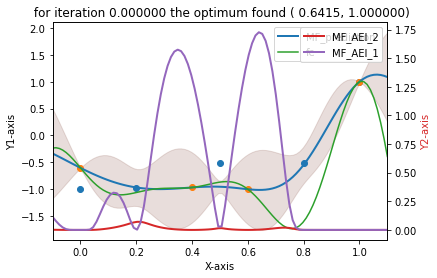

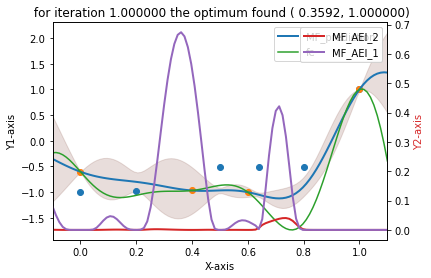

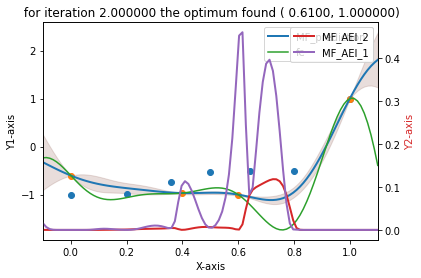

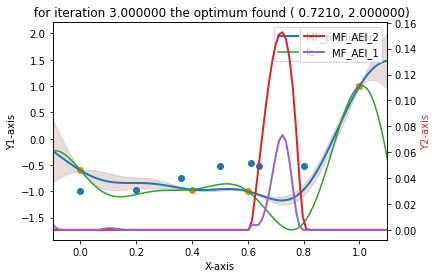

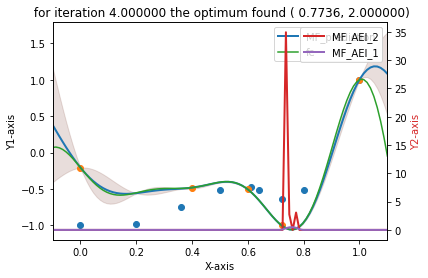

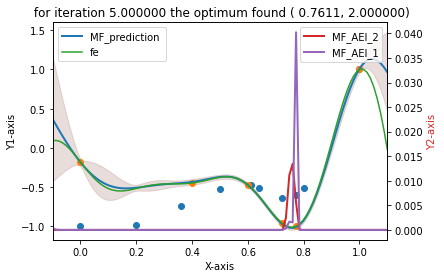

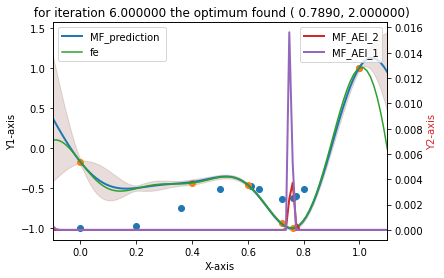

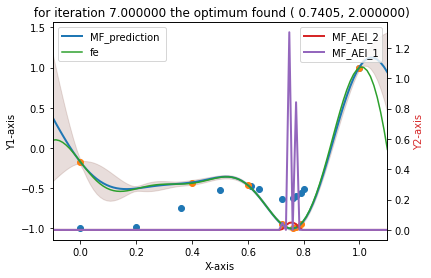

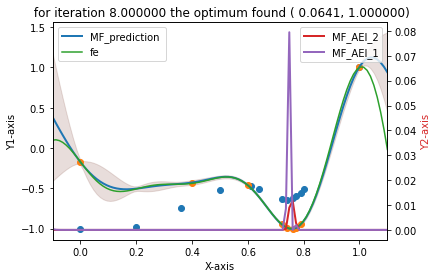

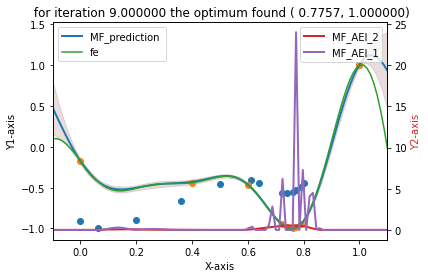

In [34]:
num_iter=10
num_parallel_optimizations=25

step=1/num_parallel_optimizations
plt.figure()
for i in range(num_iter):
    
    
    best_observation_parallel=np.zeros((num_parallel_optimizations,2))
    neg_MF_aei=np.zeros((num_parallel_optimizations,1))
    for opt in range(num_parallel_optimizations):
        x_0=(opt+1)*step*np.random.random_sample()+opt*step
        print("iteration :", opt)
        min1=minimize(neg_MF_AEI_1, float(x_0), args=(),bounds=[(0,1)],method='L-BFGS-B',options={'disp': None   ,'maxiter':15000, })
        
        min2=minimize(neg_MF_AEI_2, float(x_0), args=(),bounds=[(0,1)],method='L-BFGS-B',options={'disp': None, 'maxiter': 15000,  })
    
    
        if (min1.fun>min2.fun) :
        
            best_observation_parallel[opt]=[min2.x.reshape(1,1),int(2)]
            
            neg_MF_aei[opt]=min2.fun
        else :
            best_observation_parallel[opt]=[min1.x.reshape(1,1),int(1)]
            neg_MF_aei[opt]=min1.fun
            
            
    best_observation=best_observation_parallel[np.argmin(neg_MF_aei)]
    
    
    ## plots 
    fig, ax1 = plt.subplots()
    mean = f_hat(xx)
    var=sigma_square_hat(xx)
    color = 'tab:red'
    ax1.set_xlabel('X-axis')  
    ax1.set_ylabel('Y1-axis')  
    ax1.plot(xx, mean, 'C0',label='MF_prediction ', lw=2)
    plt.plot(xx,(f[1](xx)-1/2*(Y_max[1]+Y_min[1]))/(1/2*(Y_max[1]-Y_min[1])),'C2', label="fe")
    ax1.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C5', alpha=0.2)
    plt.scatter(data_X[0],data_Y[0])
    plt.scatter(data_X[1],data_Y[1])
    ax1.tick_params(axis ='y')  
    plt.legend()
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Y2-axis', color = color) 
    ax2.plot(xx,MF_AEI(xx,2),'C3',label='MF_AEI_2',lw=2) 
    ax2.plot(xx,MF_AEI(xx,1),'C4',label='MF_AEI_1',lw=2) 
    ax2.tick_params(axis ='y')
    plt.title(' for iteration %f the optimum found ( %.4f, %f)' %(i,best_observation[0],best_observation[1]))
    plt.legend()
    plt.xlim(-0.1, 1.1);

    # update the design of experiment  with the new observation 
    
    l_star= best_observation[1]-1
    n[l_star]+=1
    data_X[l_star]=np.concatenate([data_X[l_star],best_observation[0].reshape(1,dim)])
    l_fidelity_observation=observer[l_star](best_observation[0].reshape(1,dim))
    Y_best=l_fidelity_observation[OBJECTIVE].observations[:].reshape(1,1)
    Y[l_star]=np.concatenate([Y[l_star],Y_best])
    Y_max[l_star]=np.max(Y[l_star])
    Y_min[l_star]=np.min(Y[l_star])
    data_Y[l_star]=normalization(Y[l_star])
    

    
   
    for j in range(L) :
        
        if (j==0): 
            model[j]=gpflow.models.GPR((data_X[j], data_Y[j]),k[j],noise_variance=1e-5)
            optimizer.minimize(model[j].training_loss,variables=model[j].trainable_variables,options=dict(disp=True, maxiter=1000),)
            sigma_epsilon[j]=float(model[j].likelihood.variance.numpy())
            k_inv[j]=np.linalg.inv(k[j](data_X[j])+sigma_epsilon[j]*np.eye(n[j]))
        else :
            start =  [ro[j-1],min.x[1],min.x[2],min.x[3],sigma_epsilon[j]]
            prev_model_obs,_=predict(model[j-1],data_X[j])
            min=minimize(neg_log_likelihood, start, args=(data_X[j],data_Y[j],prev_model_obs), bounds=[(-np.inf,np.inf),(0e-4,2),(1e-4,30**2),(1e-4,np.inf),(1.1e-6,np.inf)],method='L-BFGS-B',options = {'disp':True,'maxiter':1000})
            ro[j-1]=min.x[0]
            sigma_epsilon[j]=min.x[4]
            k_=gpflow.kernels.RBF(min.x[2],min.x[1])
            theta=gpflow.kernels.Constant(min.x[3])
            k[j]=k_+theta
            k_inv[j]=np.linalg.inv(k[j](data_X[j])+sigma_epsilon[j]*np.eye(n[j]))
      

          
    DoE=np.concatenate((data_X[0],data_X[1])) ##desig of experiment 
    x_best=DoE[np.argmin(f_hat(DoE))].reshape(1,dim)
